<a href="https://colab.research.google.com/github/bhushanbkt/Gastrointestinal_img_segmentation/blob/main/Gastrointestinal_img_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Upload the kaggle.json file that you downloaded
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

 99% 1.19G/1.20G [00:12<00:00, 98.6MB/s]
100% 1.20G/1.20G [00:12<00:00, 100MB/s] 


In [4]:
import zipfile
import os

# Specify the path to the downloaded zip file
zip_file_path = '/content/kvasir-dataset-for-classification-and-segmentation.zip'

# Specify the directory to extract the contents
extracted_path = '/content/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List the files in the extracted directory
os.listdir(extracted_path)

['.config',
 'kvasir-dataset-for-classification-and-segmentation.zip',
 'kvasir-seg',
 'kvasir-dataset',
 'drive',
 'sample_data']

In [5]:
import os
import json
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io, color,transform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout


In [6]:
data_dir = '/content/kvasir-seg/Kvasir-SEG'
images_dir = os.path.join(data_dir, '/content/kvasir-seg/Kvasir-SEG/images')
masks_dir = os.path.join(data_dir, '/content/kvasir-seg/Kvasir-SEG/masks')

In [7]:
# List all image filenames in the images directory
image_filenames = os.listdir(images_dir)

In [10]:
image_filenames

['cju1gkndf6yi10801o1qnje19.jpg',
 'cju0vtox5ain6099360pu62rp.jpg',
 'cju89z6pqpqfx0817mfv8ixjc.jpg',
 'cju5yimthmlv80850zhoc90c2.jpg',
 'cjyzufihqquiw0a46jatrbwln.jpg',
 'cju5fb86jd1jp0755b1ukbhq5.jpg',
 'cju85l4yjlops0801fvmnwptf.jpg',
 'cju2xyd9vyi7m098831qcucse.jpg',
 'cju45jpvfn6c809873pv1i34s.jpg',
 'cju302fqq9spc0878rrygyzzz.jpg',
 'cju2hugv9vget0799hhk7ksvg.jpg',
 'cju34fojcctcf0799ebolbvkn.jpg',
 'cju324q101fhe08350wae9cif.jpg',
 'cju2ysg748ru80878sp6j0gm0.jpg',
 'cju6z2616wqbk07555bvnuyr1.jpg',
 'cju1dg44i4z3w0801nyz4p6zf.jpg',
 'cju3tp94kfstl08181awh6z49.jpg',
 'cju30lncba3ny0878jwnous8n.jpg',
 'cju8dqkrqu83i0818ev74qpxq.jpg',
 'cju77q10sz9ug0801449wu1nu.jpg',
 'cju43lcnum9y10755bjs7z87f.jpg',
 'cju6ut4l8va6y0755tyw3vfqq.jpg',
 'cju6z7e4bwgdd0987ogkzq9kt.jpg',
 'cju2sxf3iqbpv09937iksn8ep.jpg',
 'cju2r11x7sdgx0988o8ule0wl.jpg',
 'cju32upim1z7u0988l883nqp6.jpg',
 'cju7bduyq1rjf08719giru9ho.jpg',
 'cju5fi0yxd3ei0801v7u0yudn.jpg',
 'cju83u9ftk3ni0987qnhlcinv.jpg',
 'cju1871y11d6

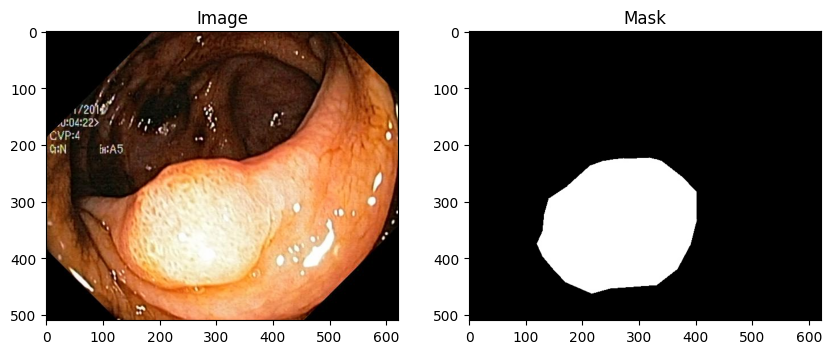

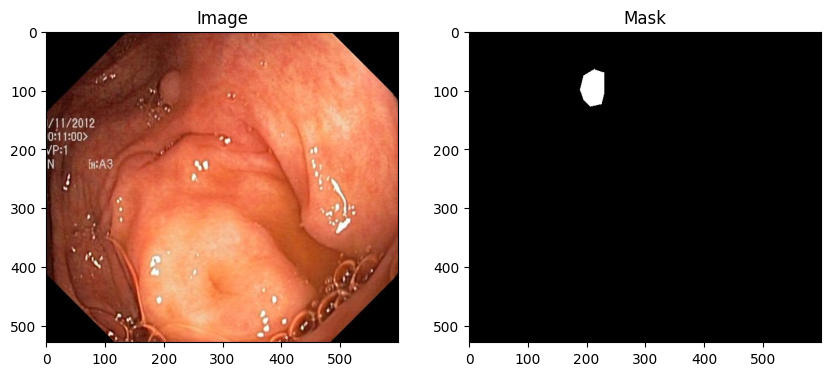

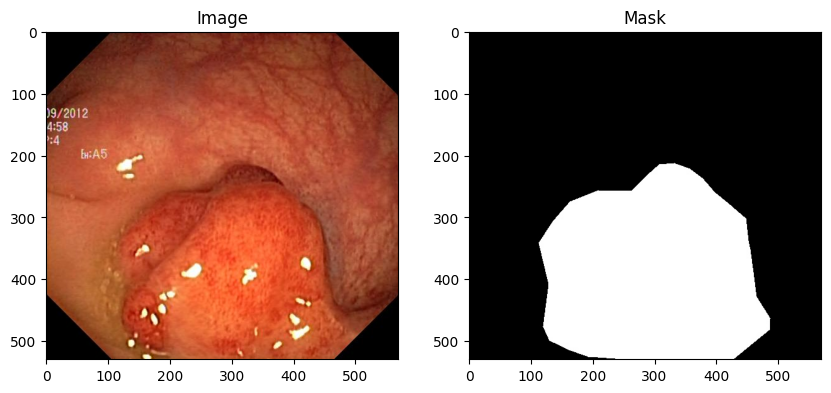

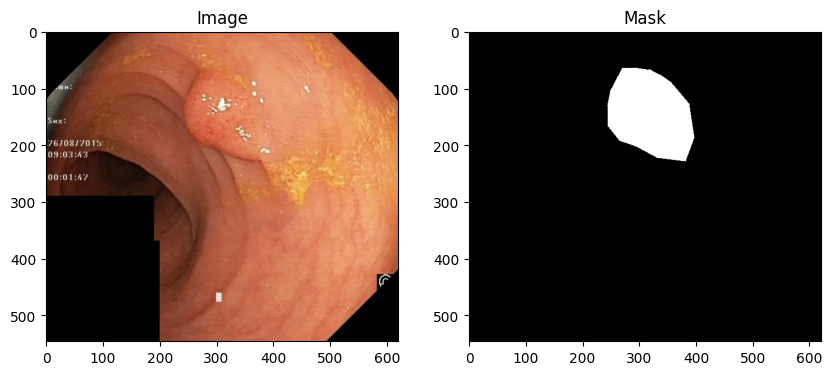

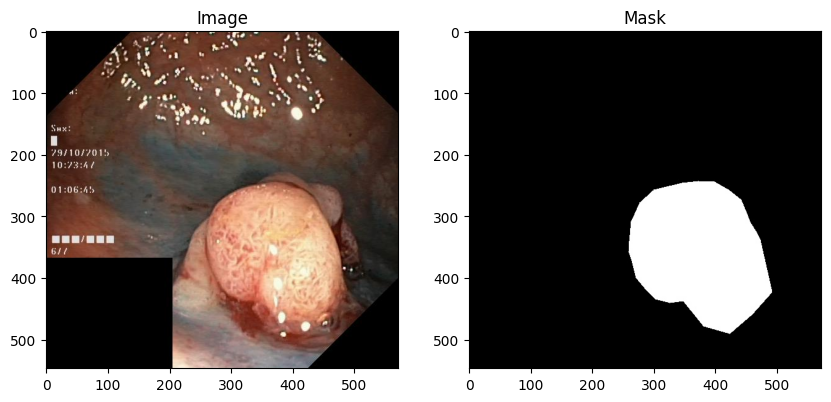

In [8]:
# Randomly select a few images for visualization
sample_images = random.sample(image_filenames, 5)

# Visualize a random sample of images and masks
for filename in sample_images:
    # Load image
    image_path = os.path.join(images_dir, filename)
    image = io.imread(image_path)

    # Load corresponding mask
    mask_filename = filename
    mask_path = os.path.join(masks_dir, mask_filename)
    mask = io.imread(mask_path)

    # Plot the image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.show()

In [9]:
# List all image filenames in the images directory
image_filenames = os.listdir(images_dir)

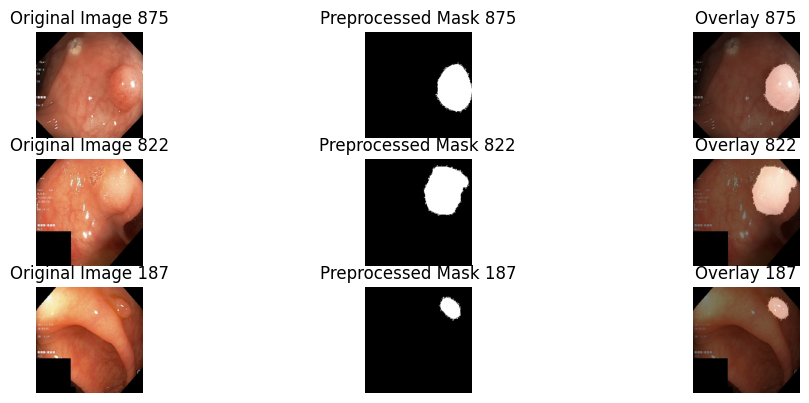

In [10]:
# Define the dimensions for resizing
IMG_HEIGHT, IMG_WIDTH = 256, 256

# List all image filenames in the images directory
image_filenames = os.listdir(images_dir)

# Initialize arrays for training data
X_train = np.zeros((len(image_filenames), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
y_train = np.zeros((len(image_filenames), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)

# Loop through images for preprocessing
for n, filename in enumerate(image_filenames):
    # Load and preprocess image
    img_path = os.path.join(images_dir, filename)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    X_train[n] = input_arr / 255.0  # Normalize to [0, 1]

    # Load and preprocess corresponding mask
    mask_filename = filename  # Assuming filenames are consistent between images and masks
    mask_path = os.path.join(masks_dir, mask_filename)
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(mask)
    y_train[n] = (input_arr > 0.7)  # Convert to binary mask

# Visualize a random sample of preprocessed images and masks
sample_indices = np.random.choice(len(image_filenames), 3, replace=False)

plt.figure(figsize=(12, 8))
for i, index in enumerate(sample_indices, start=1):
    plt.subplot(5, 3, i * 3 - 2)
    plt.imshow(X_train[index])
    plt.title(f'Original Image {index}')
    plt.axis(False)

    plt.subplot(5, 3, i * 3 - 1)
    plt.imshow(y_train[index][:, :, 0], cmap='gray')
    plt.title(f'Preprocessed Mask {index}')
    plt.axis(False)

    plt.subplot(5, 3, i * 3)
    plt.imshow(X_train[index])
    plt.imshow(y_train[index][:, :, 0], cmap='gray', alpha=0.5)
    plt.title(f'Overlay {index}')
    plt.axis(False)

plt.show()

In [20]:
# Define the dimensions for resizing
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Define image and mask preprocessing functions
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    return input_arr / 255.0  # Normalize to [0, 1]

def preprocess_mask(mask_path):
    mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(mask)
    return (input_arr > 0.7).astype(bool)  # Convert to binary mask

# Function for loading and preprocessing data
# Function for loading and preprocessing data
def load_and_preprocess_data(images_dir, masks_dir):
    image_filenames = os.listdir(images_dir)

    # Initialize arrays for training data
    X_train = np.zeros((len(image_filenames), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
    y_train = np.zeros((len(image_filenames), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  # Change dtype to bool

    # Loop through images for preprocessing
    for n, filename in enumerate(image_filenames):
        # Load and preprocess image
        img_path = os.path.join(images_dir, filename)
        X_train[n] = preprocess_image(img_path)

        # Load and preprocess corresponding mask
        mask_filename = filename  # Assuming filenames are consistent between images and masks
        mask_path = os.path.join(masks_dir, mask_filename)
        y_train[n, :, :, 0] = preprocess_mask(mask_path).squeeze()  # Use squeeze to remove the singleton dimension

    return X_train, y_train


In [19]:
X_train.shape,y_train.shape

((800, 256, 256, 3), (800, 256, 256, 3))

In [21]:
# Load and preprocess data
X_train, y_train = load_and_preprocess_data(images_dir, masks_dir)

In [46]:
# # Adjust the desired height, width, and channels
# desired_height = 256
# desired_width = 256
# channels = 3


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    concat1 = Concatenate(axis=-1)([conv3, up1])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    concat2 = Concatenate(axis=-1)([conv2, up2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    concat3 = Concatenate(axis=-1)([conv1, up3])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    return Model(inputs=inputs, outputs=outputs)



# Instantiate the model
model = unet_model(input_shape=(desired_height, desired_width, channels))

In [47]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_18[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_19[0][0]']           
 g2D)                                                                                       

In [49]:
from tensorflow.keras.optimizers import Adam

# Instantiate the model
model = unet_model(input_shape=(256, 256, 3))

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
50/50 [==============================] - 73s 757ms/step - loss: 0.6257 - accuracy: 0.8307 - val_loss: 0.4183 - val_accuracy: 0.8398
Epoch 2/10
50/50 [==============================] - 32s 649ms/step - loss: 0.3883 - accuracy: 0.8427 - val_loss: 0.3707 - val_accuracy: 0.8398
Epoch 3/10
50/50 [==============================] - 32s 645ms/step - loss: 0.3676 - accuracy: 0.8427 - val_loss: 0.3770 - val_accuracy: 0.8398
Epoch 4/10
50/50 [==============================] - 32s 642ms/step - loss: 0.3658 - accuracy: 0.8427 - val_loss: 0.3559 - val_accuracy: 0.8398
Epoch 5/10
50/50 [==============================] - 32s 648ms/step - loss: 0.3511 - accuracy: 0.8427 - val_loss: 0.3479 - val_accuracy: 0.8398
Epoch 6/10
50/50 [==============================] - 32s 646ms/step - loss: 0.3489 - accuracy: 0.8427 - val_loss: 0.3465 - val_accuracy: 0.8398
Epoch 7/10
50/50 [==============================] - 32s 647ms/step - loss: 0.3418 - accuracy: 0.8427 - val_loss: 0.3441 - val_accuracy: 0.8398

In [51]:
# Evaluate the model on the validation set
evaluation_result = model.evaluate(X_train, y_train, verbose=1)
print("Validation Loss:", evaluation_result[0])
print("Validation Accuracy:", evaluation_result[1])


32/32 [==============================] - 27s 385ms/step - loss: 0.3300 - accuracy: 0.8455
Validation Loss: 0.3300168812274933
Validation Accuracy: 0.8455178737640381


1/1 [==============================] - 0s 20ms/step


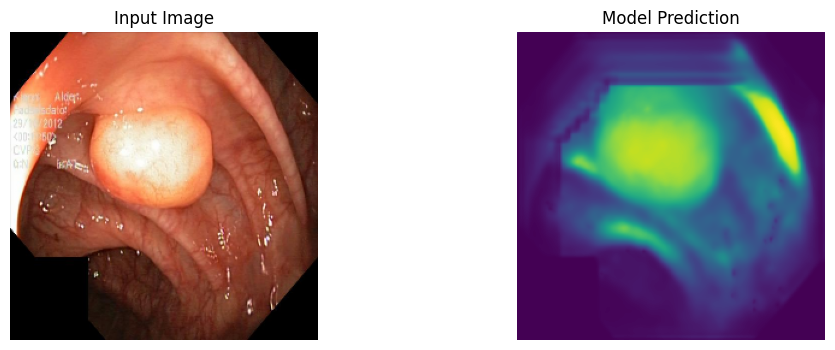

In [62]:
import cv2
import numpy as np

def preprocess_single_image(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure proper color channels
    img = cv2.resize(img, (desired_width, desired_height))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

def make_prediction(model, image_path):
    # Preprocess the single image
    input_image = preprocess_single_image(image_path)

    # Expand dimensions to create batch-like shape (1, height, width, channels)
    input_image = np.expand_dims(input_image, axis=0)

    # Make prediction
    prediction = model.predict(input_image)[0]

    return prediction

# Example usage
image_path = '/content/kvasir-seg/Kvasir-SEG/images/cju18849rrsgr0988p90hkygb.jpg'
prediction = make_prediction(model, image_path)

# Visualize the input image and the model prediction with a color map
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(preprocess_single_image(image_path))
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction[:, :, 0], cmap='viridis')
plt.title('Model Prediction')
plt.axis('off')

plt.show()


1/1 [==============================] - 0s 19ms/step


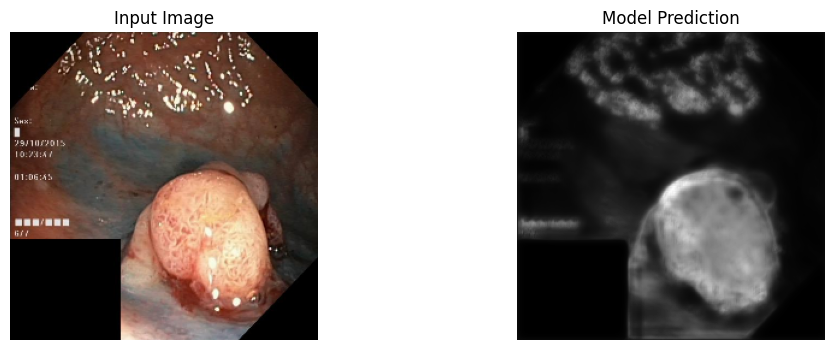

In [45]:
import cv2
import numpy as np

def preprocess_single_image(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure proper color channels
    img = cv2.resize(img, (desired_width, desired_height))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

def make_prediction(model, image_path):
    # Preprocess the single image
    input_image = preprocess_single_image(image_path)

    # Expand dimensions to create batch-like shape (1, height, width, channels)
    input_image = np.expand_dims(input_image, axis=0)

    # Make prediction
    prediction = model.predict(input_image)[0]

    return prediction

# Example usage
image_path = '/content/kvasir-seg/Kvasir-SEG/images/cju1f15k3w4ct0835cmde6ypo.jpg'
prediction = make_prediction(model, image_path)

# Visualize the input image and the model prediction
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(preprocess_single_image(image_path))
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction[:, :, 0], cmap='gray')
plt.title('Model Prediction')
plt.axis('off')

plt.show()


In [60]:
# Save the model
model.save('/content/drive/MyDrive/Dataset/seg_model')
